## Imports

In [5]:
import os
import cv2
import time
import torch
import pathlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchmetrics.segmentation import MeanIoU
from torch.utils.data import DataLoader, Dataset

## Function to split data into train & val ensuring equal distribution of classes across

In [2]:
def stratified_split(images, masks, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    num_samples = len(images)
    
    # Flatten masks to determine class distributions
    mask_labels = masks.reshape(num_samples, -1).mean(axis=1).astype(int)  # Approx class labels
    
    # Get unique classes and their indices
    unique_classes, class_counts = np.unique(mask_labels, return_counts=True)
    
    train_indices = []
    val_indices = []
    
    for cls in unique_classes:
        cls_indices = np.where(mask_labels == cls)[0]
        np.random.shuffle(cls_indices)
        split_idx = int(len(cls_indices) * (1 - test_size))
        
        train_indices.extend(cls_indices[:split_idx])
        val_indices.extend(cls_indices[split_idx:])
    
    # Shuffle final indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    train_images, val_images = images[train_indices], images[val_indices]
    train_masks, val_masks = masks[train_indices], masks[val_indices]
    
    return train_images, val_images, train_masks, val_masks

## Read Data and split into train and val

In [3]:
def read_images_masks(folder_path, ext=".png"):
    images_folder = f"{folder_path}/images"
    masks_folder = f"{folder_path}/labels"
    file_names = [f for f in os.listdir(images_folder) if f.endswith(ext)]
    all_images = []
    all_masks = []
    for file in file_names:
        all_images.append(cv2.cvtColor(cv2.imread(f"{images_folder}/{file}"), cv2.COLOR_BGR2RGB))
        img = cv2.cvtColor(cv2.imread(f"{masks_folder}/{file}"), cv2.COLOR_BGR2RGB)
        all_masks.append(img[:, :, 0])  # Extract the first channel
    return np.array(all_images), np.array(all_masks)

train_images, train_masks = read_images_masks("/kaggle/input/semantic-segmentation-dataset-256/dataset_256/train")
train_images, val_images, train_masks, val_masks = stratified_split(train_images, train_masks)
test_images, test_masks = read_images_masks("/kaggle/input/semantic-segmentation-dataset-256/dataset_256/test")
print(f"Number of train images = {len(train_images)}")
print(f"Number of train masks = {len(train_masks)}")
print(f"Number of val images = {len(val_images)}")
print(f"Number of val masks = {len(val_masks)}")
print(f"Number of test images = {len(test_images)}")
print(f"Number of test masks = {len(test_masks)}")

Number of train images = 1598
Number of train masks = 1598
Number of val images = 402
Number of val masks = 402
Number of test images = 500
Number of test masks = 500


## Shape of images and masks

In [4]:
print(train_images[0].shape, train_masks[0].shape)

(256, 256, 3) (256, 256)


## Map from class number to class name

In [5]:
_class = {
    0: "Unlabelled",
    1: "Building",
    2: "Fence",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "Roadline",
    7: "Road",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Car",
    11: "Wall",
    12: "Traffic Sign"
}

seg_map = 'jet'

## Visualising Data

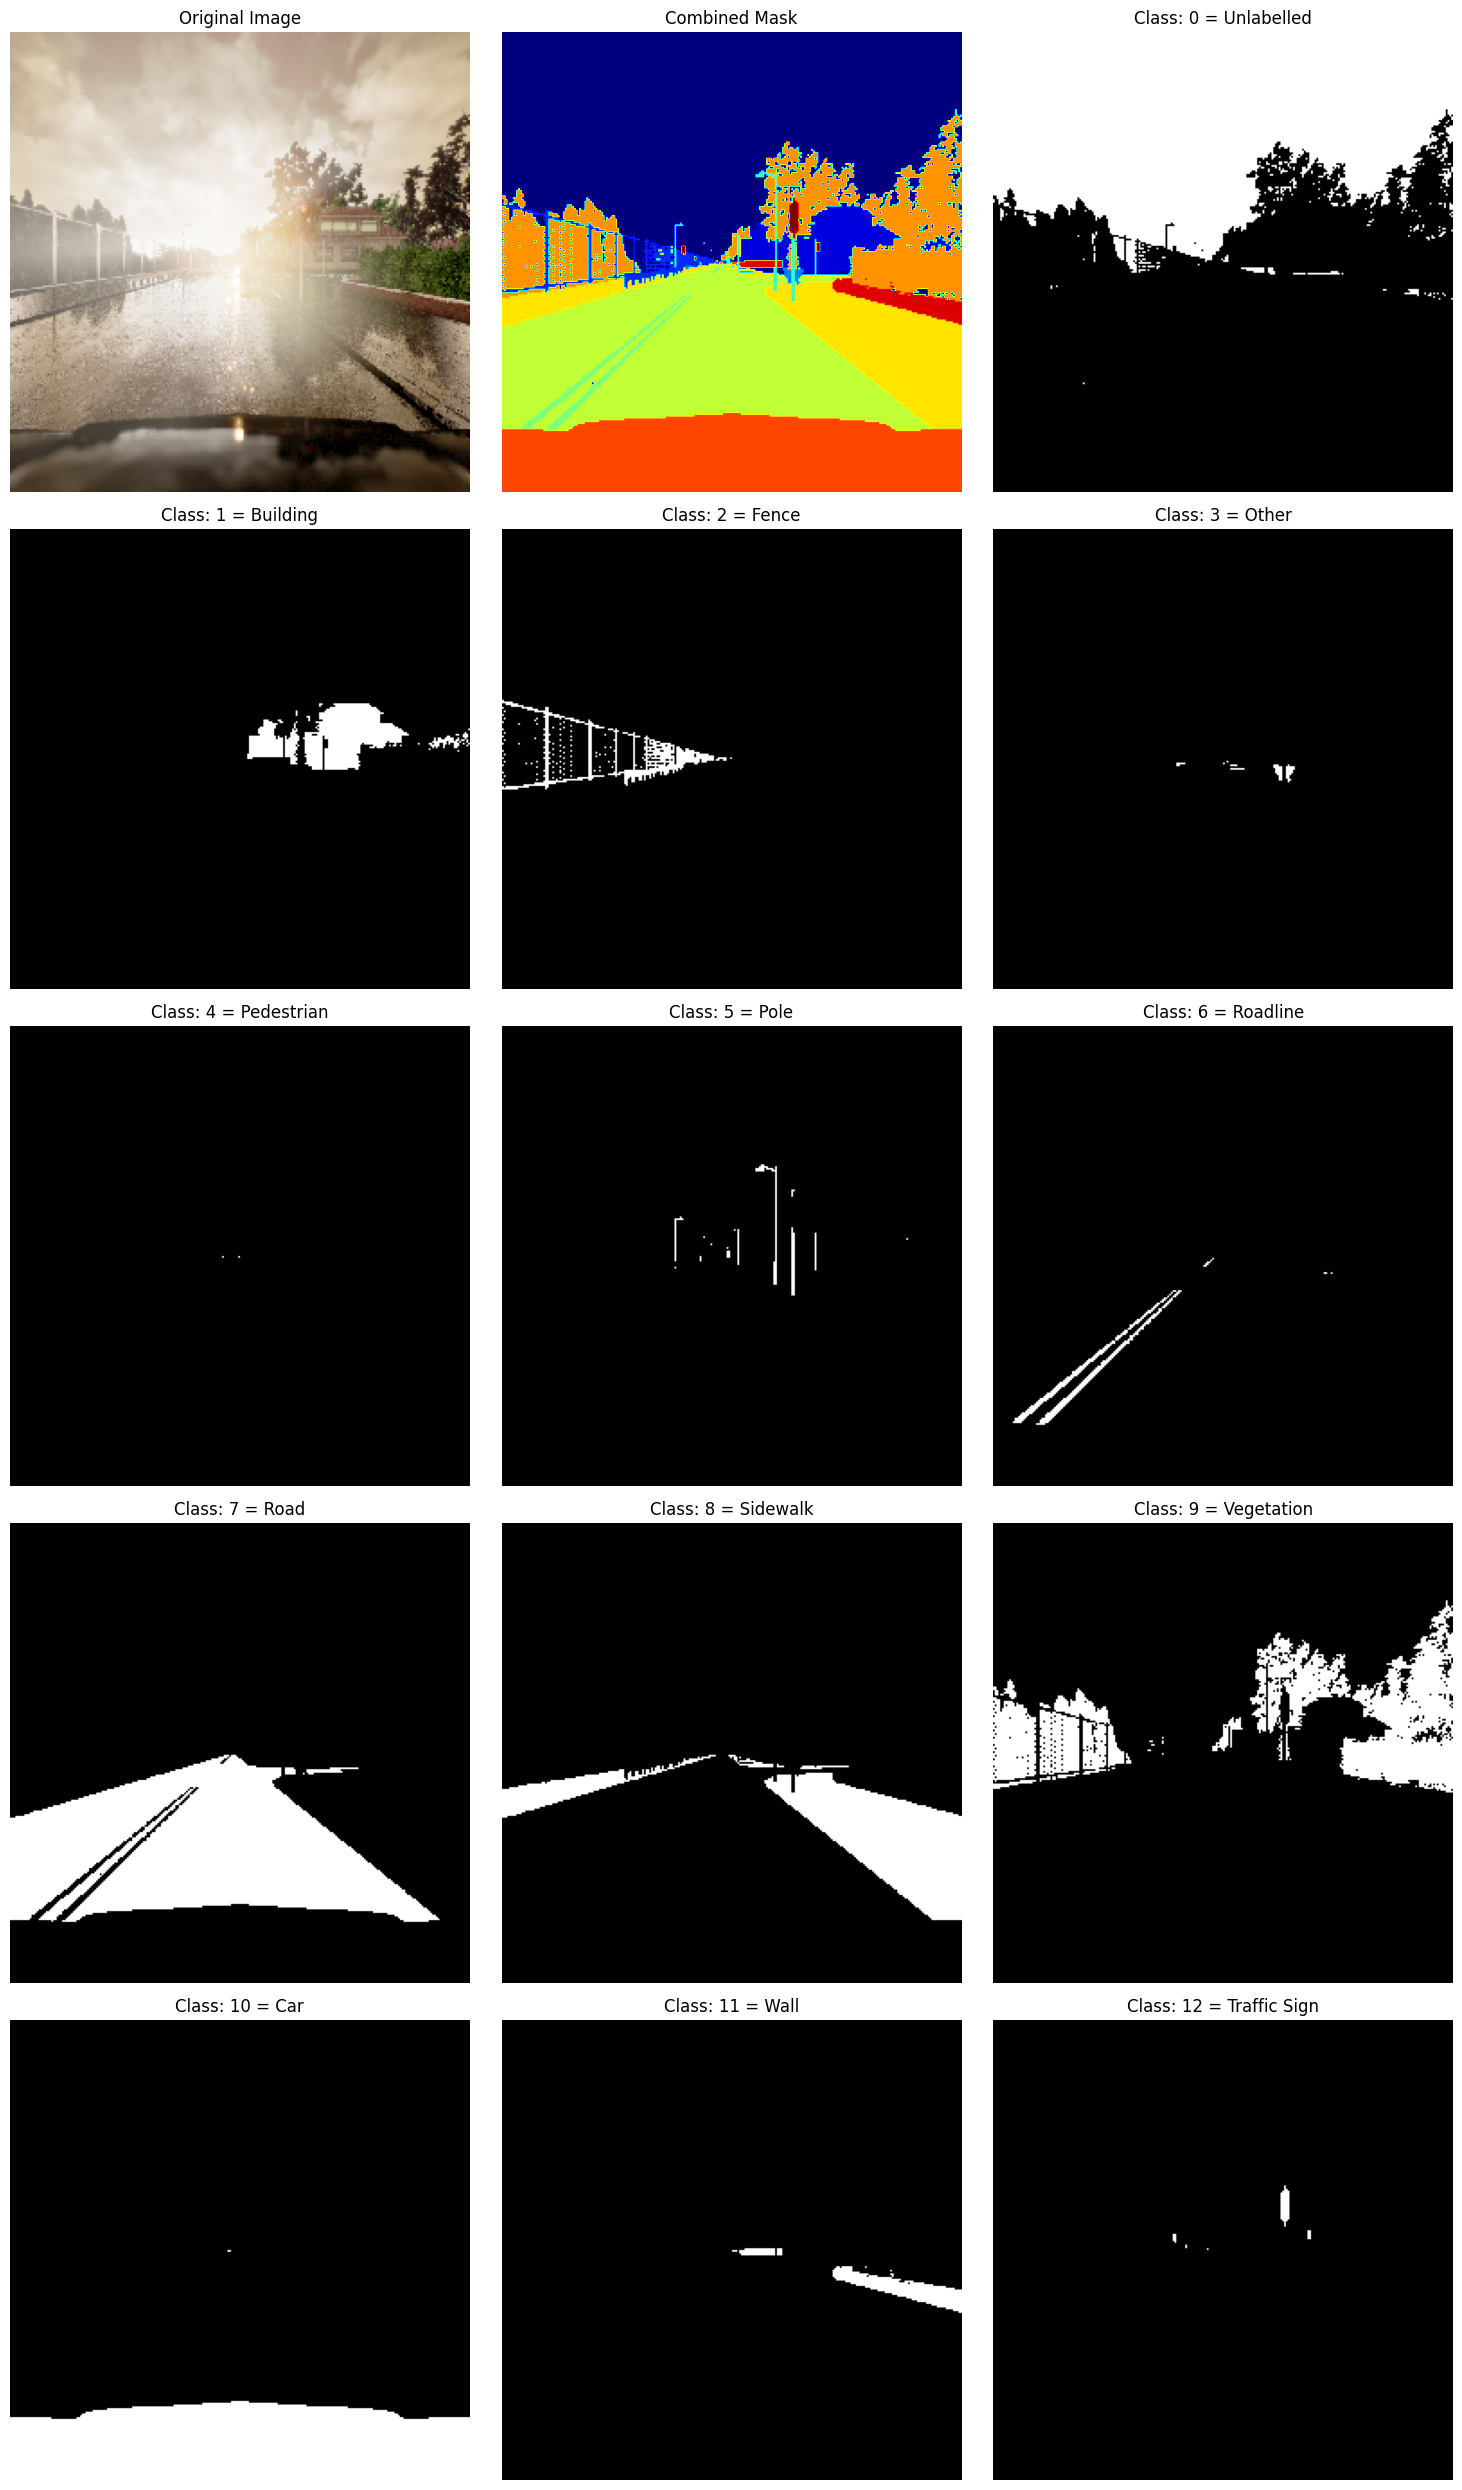

In [6]:
def visualise_masks(img_arr, mask_arr):
    samples_visualised = 0
    
    for img, mask in zip(img_arr, mask_arr):        
        # List of all the classes present in the mask/image
        classes_present = np.unique(mask)

        # Plot only the good masks where all the classes are present
        if len(classes_present) == 13:
            fig, axes = plt.subplots(5, 3, figsize=(15, 25)) # Original Image + Combined Mask + Individual Masks = 15 total images
            axes = axes.ravel()
            
            axes[0].imshow(img)
            axes[0].axis('off')
            axes[0].set_title("Original Image")

            axes[1].imshow(mask, cmap=seg_map)
            axes[1].axis('off')
            axes[1].set_title("Combined Mask")
            
            for idx, cls in enumerate(classes_present):
                binary_mask = np.where(mask == cls, 1, 0)
                axes[idx + 2].imshow(binary_mask, cmap='gray')
                axes[idx + 2].axis('off')
                axes[idx + 2].set_title(f"Class: {cls} = {_class[cls]}")
            plt.tight_layout()
            plt.show()

            break

visualise_masks(train_images, train_masks)

## Architectures

To keep the output segmentation mask dimensions as close as the given images I have modified the shapes of the layers of U-Net accordingly to fit this question. For getting input images of 412x412 dimensions I will be mirroring the pixel on over the edge to create the larger image.

### Vanilla UNet

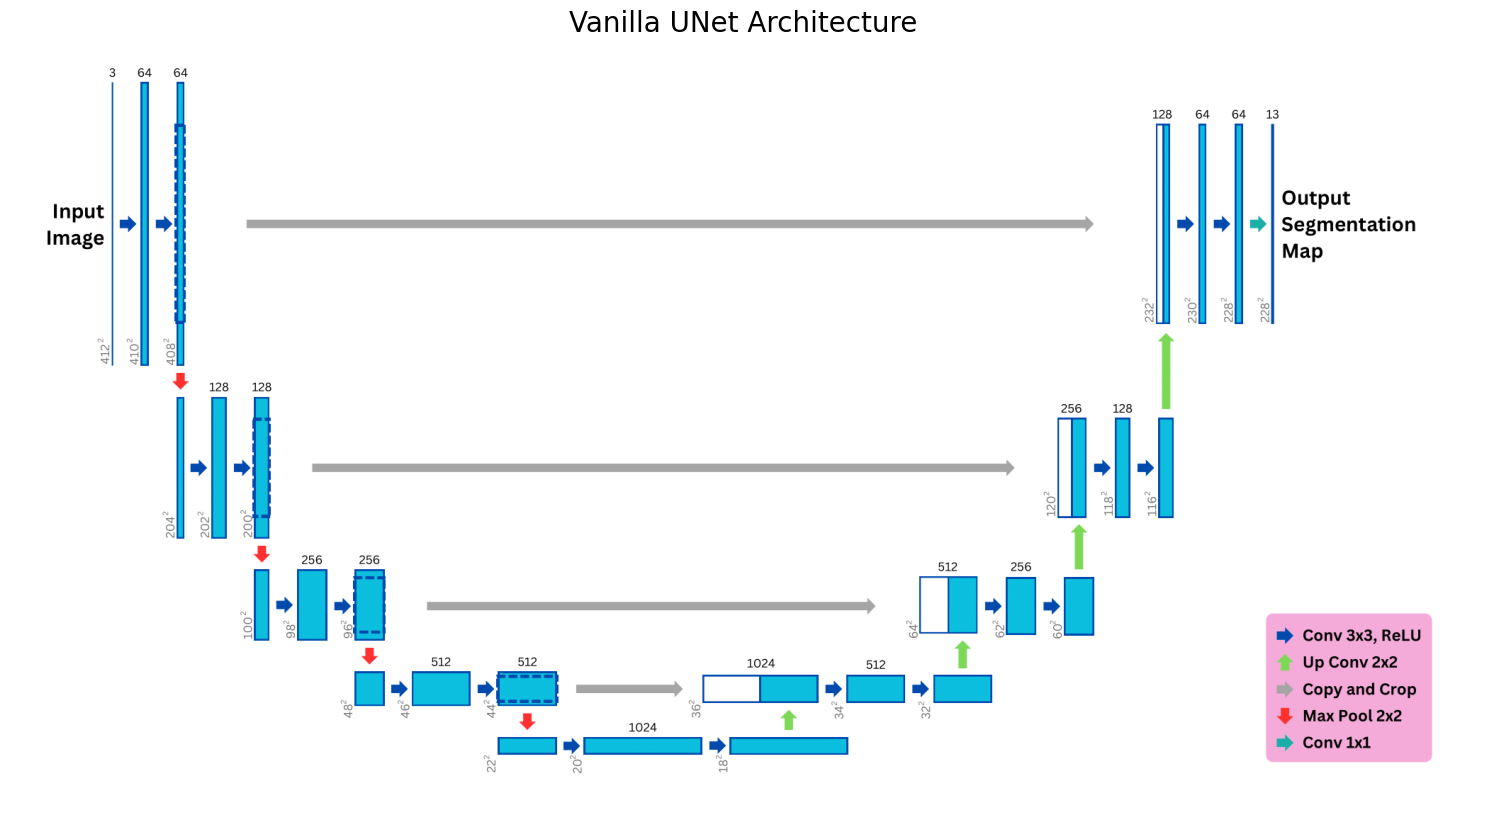

In [7]:
arch = cv2.imread("/kaggle/input/architectures/unet_architectures/unet-arch.png")
arch = cv2.cvtColor(arch, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(arch)
plt.title("Vanilla UNet Architecture", fontsize=20)
plt.axis('off')
plt.show()

### Skip Connection Less UNet

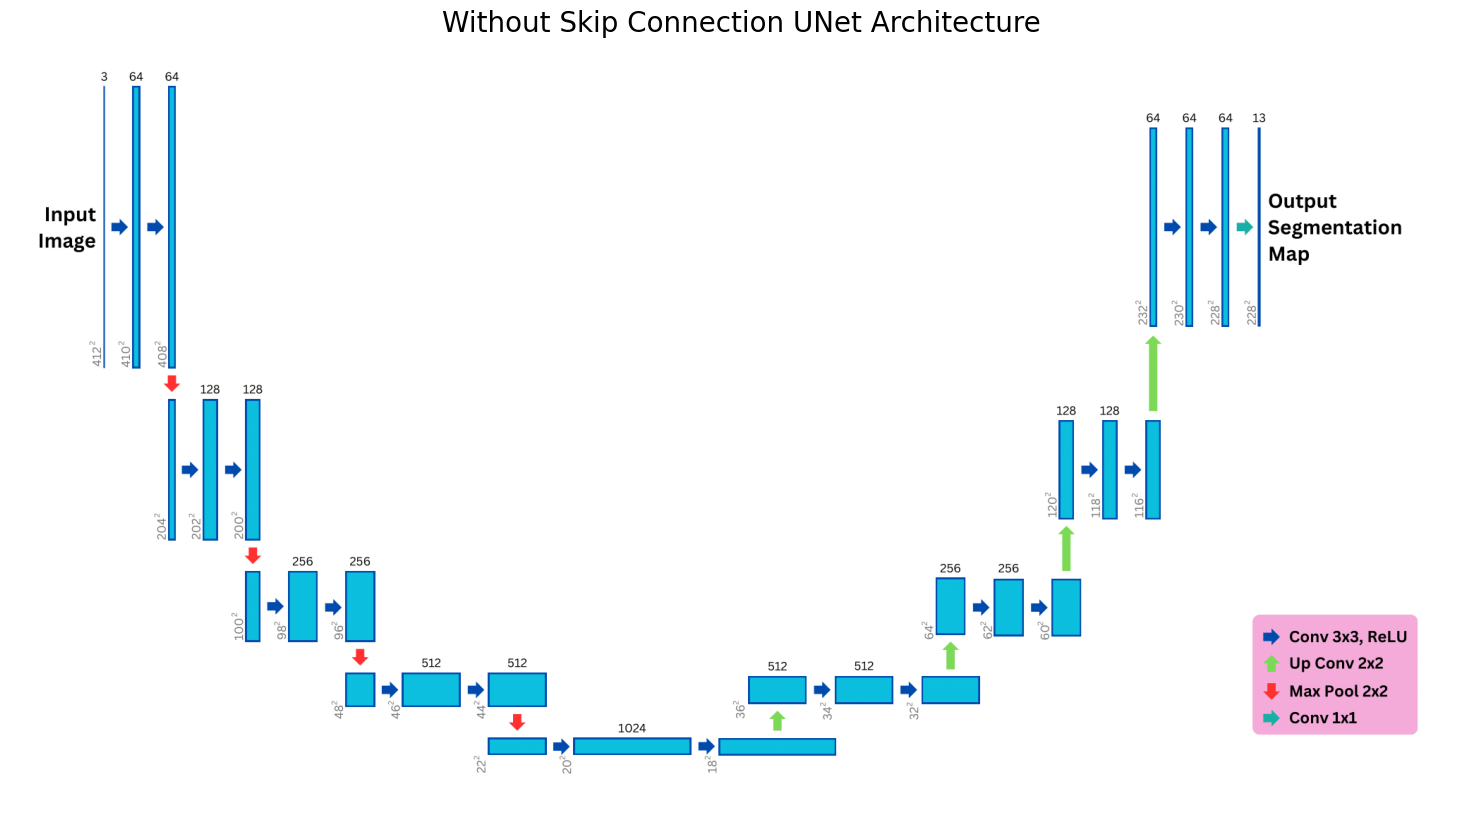

In [8]:
skipless_arch = cv2.imread("/kaggle/input/architectures/unet_architectures/skipless-unet-arch.png")
skipless_arch = cv2.cvtColor(skipless_arch, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(skipless_arch)
plt.title("Without Skip Connection UNet Architecture", fontsize=20)
plt.axis('off')
plt.show()

### Residual UNet

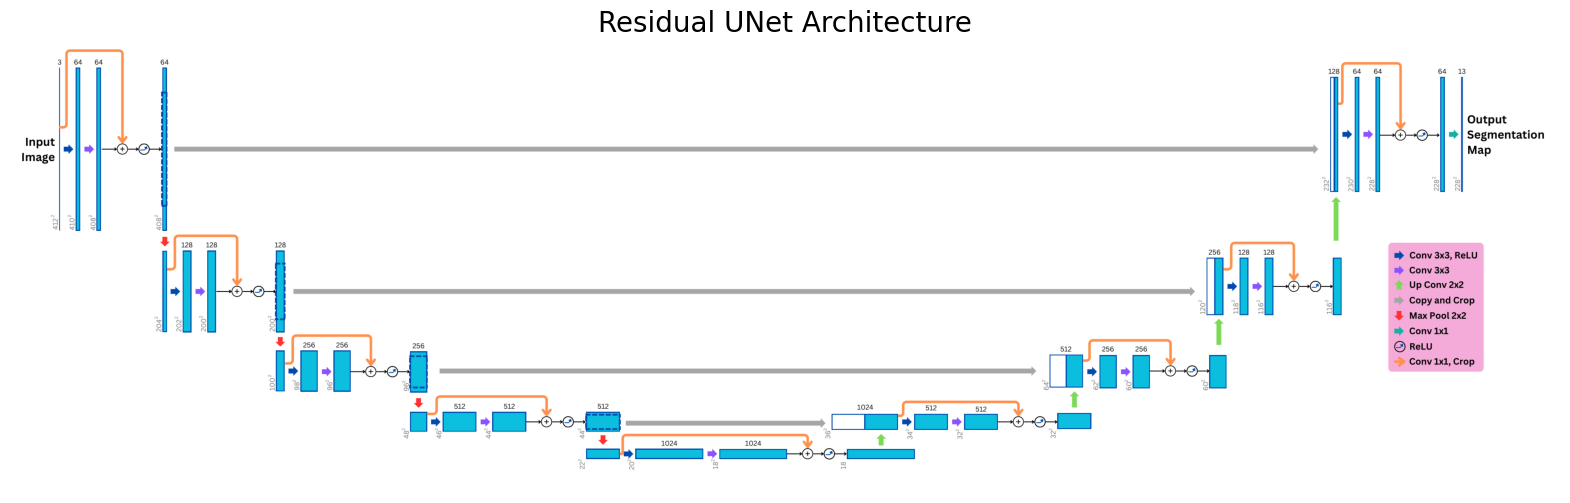

In [9]:
residual_arch = cv2.imread("/kaggle/input/architectures/unet_architectures/residual-unet-arch.png")
residual_arch = cv2.cvtColor(residual_arch, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(residual_arch)
plt.title("Residual UNet Architecture", fontsize=20)
plt.axis('off')
plt.show()

### Gated Attention Unet

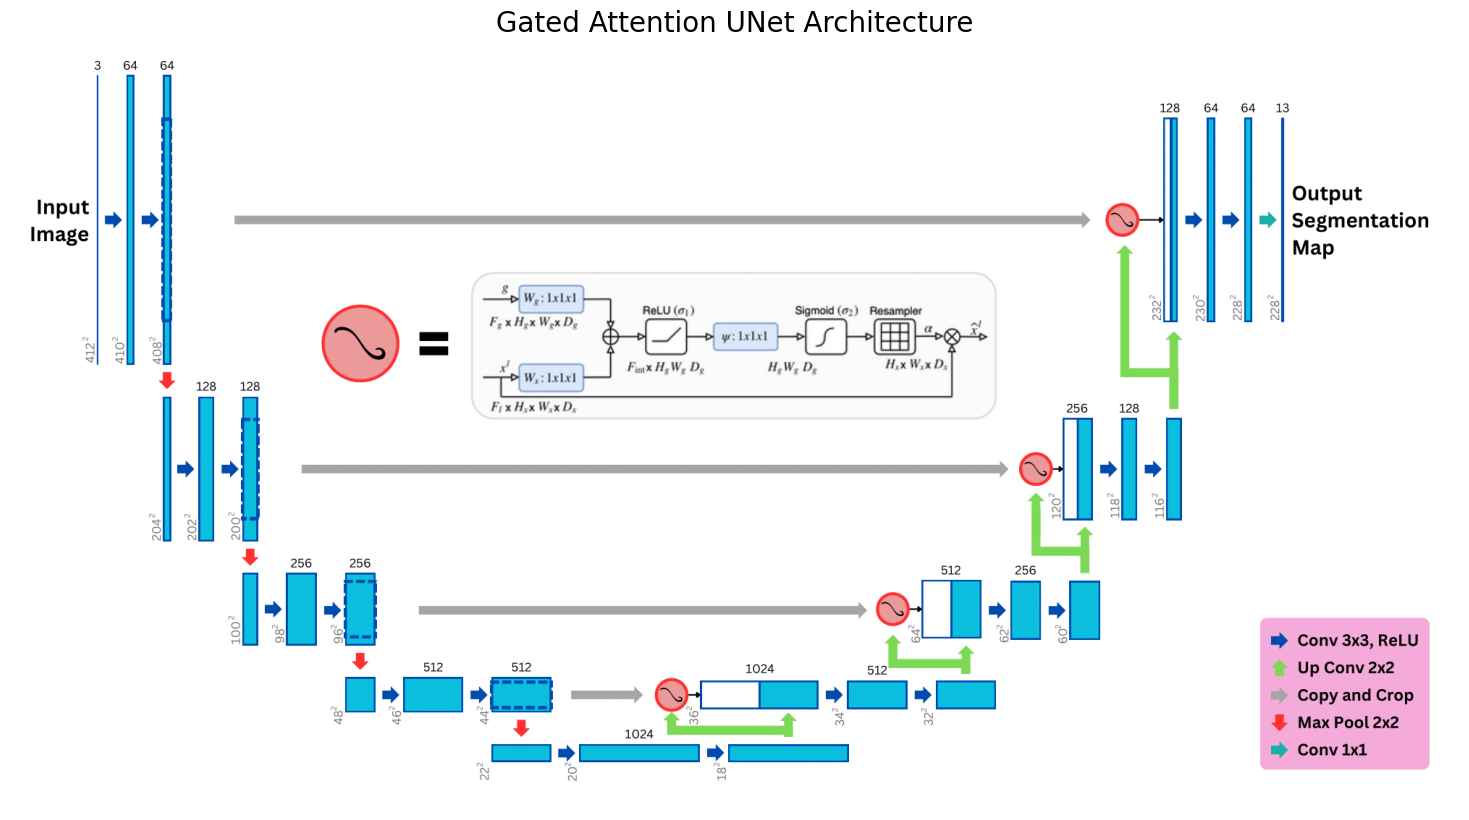

In [10]:
gated_attention_arch = cv2.imread("/kaggle/input/architectures/unet_architectures/gated-attention-unet-arch.png")
gated_attention_arch = cv2.cvtColor(gated_attention_arch, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(gated_attention_arch)
plt.title("Gated Attention UNet Architecture", fontsize=20)
plt.axis('off')
plt.show()

## Preprocessing input - Mirror padding input images and cropping the masks

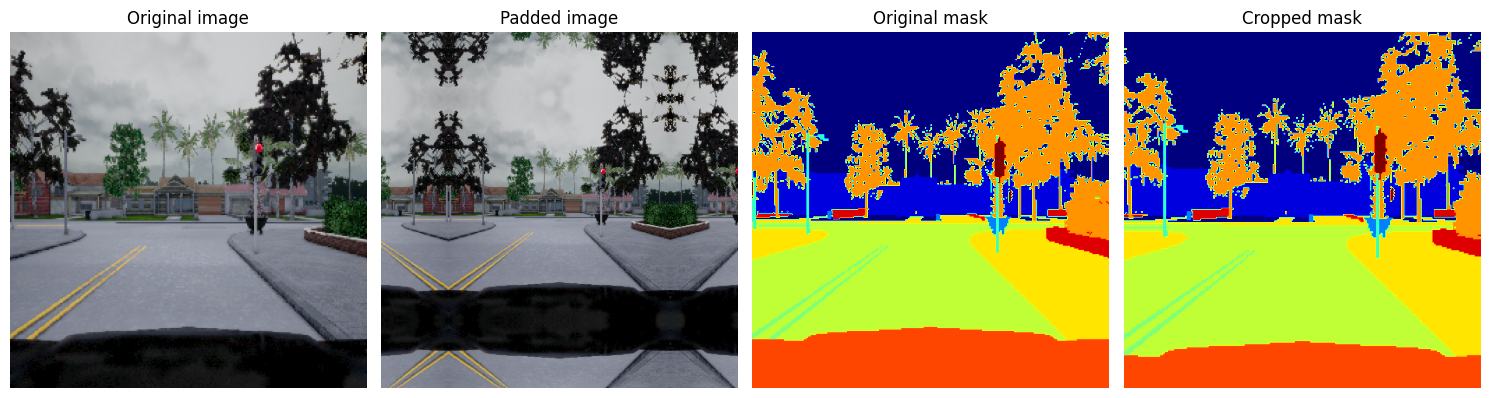

In [11]:
def pad_images(images, pad_size):
    padded_images = []
    for img in images:
        padded_img = cv2.copyMakeBorder(
            img, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT
        )
        padded_images.append(padded_img)
    return np.array(padded_images)

def center_crop(img, crop_size):
    h, w = img.shape
    new_h, new_w = crop_size

    start_x = (w - new_w) // 2
    start_y = (h - new_h) // 2

    cropped_img = img[start_y:start_y + new_h, start_x:start_x + new_w]
    return cropped_img

def crop_images(images, crop_size):
    cropped_images = []
    for img in images:
        cropped_img = center_crop(img, crop_size)
        cropped_images.append(cropped_img)
    return cropped_images

def save_images(images, save_folder):
    for i in range(len(images)):
        image_path = os.path.join(save_folder, f"image_{i}.png")
        if len(images[i].shape) == 2:
            bgr_image = cv2.cvtColor(cv2.merge((images[i], images[i], images[i])), cv2.COLOR_BGR2RGB)
        else:
            bgr_image = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
        cv2.imwrite(image_path, bgr_image)

# Define padding size
pad_size = (412 - 256) // 2  # 78 pixels on each side

padded_train_images = pad_images(train_images, pad_size)
padded_val_images = pad_images(val_images, pad_size)
padded_test_images = pad_images(test_images, pad_size)
cropped_train_masks = crop_images(train_masks, (228, 228))
cropped_val_masks = crop_images(val_masks, (228, 228))
cropped_test_masks = crop_images(test_masks, (228, 228))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(train_images[0])
axes[0].axis('off')
axes[0].set_title("Original image")

axes[1].imshow(padded_train_images[0])
axes[1].axis('off')
axes[1].set_title("Padded image")

axes[2].imshow(train_masks[0], cmap=seg_map)
axes[2].axis('off')
axes[2].set_title("Original mask")

axes[3].imshow(cropped_train_masks[0], cmap=seg_map)
axes[3].axis('off')
axes[3].set_title("Cropped mask")

plt.tight_layout()
plt.show()

# Saving the transformed images and masks
# path = pathlib.Path("/kaggle/working/data").mkdir(exist_ok=True)
# path = pathlib.Path("/kaggle/working/data/train").mkdir(exist_ok=True)
# path = pathlib.Path("/kaggle/working/data/test").mkdir(exist_ok=True)
# path = pathlib.Path("/kaggle/working/data/train/images").mkdir(exist_ok=True)
# path = pathlib.Path("/kaggle/working/data/train/labels").mkdir(exist_ok=True)
# path = pathlib.Path("/kaggle/working/data/test/images").mkdir(exist_ok=True)
# path = pathlib.Path("/kaggle/working/data/test/labels").mkdir(exist_ok=True)
# save_images(padded_train_images, "/kaggle/working/data/train/images")
# save_images(cropped_train_masks, "/kaggle/working/data/train/labels")
# save_images(padded_test_images, "/kaggle/working/data/test/images")
# save_images(cropped_test_masks, "/kaggle/working/data/test/labels")
# print("Saved the padded and cropped images.")

## Main Model Class

<span style="color:red">Note: I am keeping the intermediate dimension in gated attention block to be the mid point of dimension of skip input and coarse input</span>

In [12]:
# Double Conv Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Residual Conv Block
class ResidualConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels)
        )
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True) # ReLU should be applied after the addition of input
        
    def forward(self, x):
        skip = self.skip(x)
        out = self.conv(x)

        # Cropping the skip connection input as the out
        # has been passed through 2 3x3 conv layers
        # hence reducing it's dimensions by 4
        _, _, H, W = skip.shape
        _, _, new_h, new_w = out.shape
        start_h = (H - new_h) // 2
        start_w = (W - new_w) // 2
        cropped_skip = skip[:, :, start_h:start_h + new_h, start_w:start_w + new_w]
        
        out += cropped_skip
        return self.relu(out)

# Gated Attention Block
class GatedAttention(nn.Module):
    def __init__(self, in_channels_skip, in_channels_coarse):
        super(GatedAttention, self).__init__()
        self.out_channels = in_channels_skip
        self.int_channels = int((in_channels_skip + in_channels_coarse) / 2)

        # Bring down both g and x to intermediate number of channels
        self.W_g = nn.Conv2d(in_channels_coarse, self.int_channels, kernel_size=1)
        self.W_x = nn.Conv2d(in_channels_skip, self.int_channels, kernel_size=1)
        # Bring down intermediate number of channels to single channel alpha
        # Alpha can also be multi-channel but here I am implementing as paper has implementd
        self.psi = nn.Conv2d(self.int_channels, 1, kernel_size=1)

    def forward(self, x, g):
        g1 = self.W_g(g)  # Transform gating signal
        x1 = self.W_x(x)  # Transform input feature maps

        # Cropping the x1 to H_g x W_g
        _, _, H_x, W_x = x1.shape
        _, _, H_g, W_g = g1.shape
        start_h = (H_x - H_g) // 2
        start_w = (W_x - W_g) // 2
        cropped_x1 = x1[:, :, start_h:start_h + H_g, start_w:start_w + W_g]

        psi = torch.relu(g1 + cropped_x1)  # Apply non-linearity
        alpha = torch.sigmoid(self.psi(psi))  # Generate attention map

        # Upsampling alpha to match HxW dimension of x (right now alpha has dimension of H_g x W_g)
        alpha = F.interpolate(alpha, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True)

        return x * alpha  # Multiply alpha to each channel of x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, model_type="vanilla"):
        super(UNet, self).__init__()
        self.model_type = model_type
        self.n_classes = out_channels

        self.pool = nn.MaxPool2d(2, 2)

        if model_type == "residual":
            ConvBlock = ResidualConv
        else:
            ConvBlock = DoubleConv

        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.enc5 = ConvBlock(512, 1024)

        # Decoder (with skip connections)
        if model_type == "vanilla" or model_type == "residual" or model_type == "gated_attention":
            self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
            self.dec4 = ConvBlock(1024, 512)
    
            self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.dec3 = ConvBlock(512, 256)
    
            self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.dec2 = ConvBlock(256, 128)
    
            self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.dec1 = ConvBlock(128, 64)

        # Decoder (without skip connections)
        if model_type == "skipless":
            self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
            self.dec4 = ConvBlock(512, 512)
    
            self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.dec3 = ConvBlock(256, 256)
    
            self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.dec2 = ConvBlock(128, 128)
    
            self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.dec1 = ConvBlock(64, 64)

        if model_type == "gated_attention":
            self.gate4 = GatedAttention(512, 1024)
            self.gate3 = GatedAttention(256, 512)
            self.gate2 = GatedAttention(128, 256)
            self.gate1 = GatedAttention(64, 128)

        # Output layer (Used for changing the number of channels to desired number of classes)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding Path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        # Decoding Path
        d4 = self.up4(e5) # Upsampling prev layer output
        if self.model_type == "vanilla" or self.model_type == "residual" or self.model_type == "gated_attention":
            # Cropping the skip connection input to match the upsampled HxW
            cropped_e4 = self.crop_center(e4, (36, 36))
            
            # Appling gate to cropped skip connection and not upsampled output from prev layer
            if self.model_type == "gated_attention":
                cropped_e4 = self.gate4(cropped_e4, e5)
            
            # Appending the transformed skip connection input to upsampled output from prev layer
            d4 = torch.cat((cropped_e4, d4), dim=1)
        d4 = self.dec4(d4) # This layer decoding

        d3 = self.up3(d4) # Upsampling prev layer output
        if self.model_type == "vanilla" or self.model_type == "residual" or self.model_type == "gated_attention":
            # Cropping the skip connection input to match the upsampled HxW
            cropped_e3 = self.crop_center(e3, (64, 64))
            
            # Appling gate to cropped skip connection and not upsampled output from prev layer
            if self.model_type == "gated_attention":
                cropped_e3 = self.gate3(cropped_e3, d4)
            
            # Appending the transformed skip connection input to upsampled output from prev layer
            d3 = torch.cat((cropped_e3, d3), dim=1)
        d3 = self.dec3(d3) # This layer decoding

        d2 = self.up2(d3) # Upsampling prev layer output
        if self.model_type == "vanilla" or self.model_type == "residual" or self.model_type == "gated_attention":
            # Cropping the skip connection input to match the upsampled HxW
            cropped_e2 = self.crop_center(e2, (120, 120))
            
            # Appling gate to cropped skip connection and not upsampled output from prev layer
            if self.model_type == "gated_attention":
                cropped_e2 = self.gate2(cropped_e2, d3)
            
            # Appending the transformed skip connection input to upsampled output from prev layer
            d2 = torch.cat((cropped_e2, d2), dim=1)
        d2 = self.dec2(d2) # This layer decoding

        d1 = self.up1(d2) # Upsampling prev layer output
        if self.model_type == "vanilla" or self.model_type == "residual" or self.model_type == "gated_attention":
            # Cropping the skip connection input to match the upsampled HxW
            cropped_e1 = self.crop_center(e1, (232, 232))
            
            # Appling gate to cropped skip connection and not upsampled output from prev layer
            if self.model_type == "gated_attention":
                cropped_e1 = self.gate1(cropped_e1, d2)
            
            # Appending the transformed skip connection input to upsampled output from prev layer
            d1 = torch.cat((cropped_e1, d1), dim=1)
        d1 = self.dec1(d1) # This layer decoding

        out = self.out_conv(d1)
        return out

    def crop_center(self, t, crop_size):
        B, C, H, W = t.shape

        new_h, new_w = crop_size

        start_h = (H - new_h) // 2
        start_w = (W - new_w) // 2

        cropped_t = t[:, :, start_h:start_h + new_h, start_w:start_w + new_w]
        return cropped_t

    def train_model(self, train_loader, val_loader, device, num_epochs=20, lr=1e-4, momentum=0.99, optimiser='adam', loss_func='cross_entropy'):
        if loss_func == 'cross_entropy':
            criterion = nn.CrossEntropyLoss()
        
        trainable_params = [p for p in self.parameters() if p.requires_grad]
        if optimiser == 'sgd':
            optimiser = optim.SGD(trainable_params, lr=lr, momentum=momentum)
        elif optimiser == 'adam':
            optimiser = optim.Adam(trainable_params, lr=lr)
            
        # Metrics
        miou_metric = MeanIoU(num_classes=self.n_classes).to(device)
        
        # Training loop
        train_losses, val_losses = [], []
        train_miou, val_miou = [], []
        
        for epoch in range(num_epochs):
            self.train()
            epoch_loss, epoch_miou = 0, 0
            
            train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        
            for images, masks in train_loader_tqdm:
                images, masks = images.to(device), masks.to(device)
        
                optimiser.zero_grad()
                preds = self.forward(images)
        
                loss = criterion(preds, masks)
                loss.backward()
                optimiser.step()
        
                # Calculate batch metrics
                epoch_loss += loss.item()
                pred_classes = torch.argmax(preds, dim=1)  # Convert [B, 13, H, W] to [B, H, W]
                epoch_miou += miou_metric(pred_classes, masks).item()
        
                train_loader_tqdm.set_postfix(loss=loss.item())
        
            train_losses.append(epoch_loss / len(train_loader))
            train_miou.append(epoch_miou / len(train_loader))
        
            # Validation
            self.eval()
            val_loss, val_miou_score = 0, 0
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        
            with torch.no_grad():
                for images, masks in val_loader_tqdm:
                    images, masks = images.to(device), masks.to(device)
                    preds = self.forward(images)
        
                    loss = criterion(preds, masks)
                    val_loss += loss.item()
        
                    pred_classes = torch.argmax(preds, dim=1)  # Convert [B, 13, H, W] to [B, H, W]
                    val_miou_score += miou_metric(pred_classes, masks).item()
        
                    val_loader_tqdm.set_postfix(loss=loss.item())
        
            val_losses.append(val_loss / len(val_loader))
            val_miou.append(val_miou_score / len(val_loader))
        
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={round(train_losses[-1], 4)}, Val Loss={round(val_losses[-1], 4)}, Train mIoU={round(train_miou[-1], 4)}, Val mIoU={round(val_miou[-1], 4)}") 

        return train_losses, train_miou, val_losses, val_miou

    def test_model(self, test_loader, device, loss_func='cross_entropy'):
        if loss_func == 'cross_entropy':
            criterion = nn.CrossEntropyLoss()

        miou_metric = MeanIoU(num_classes=self.n_classes).to(device)

        test_loss, test_miou_score = 0, 0
        all_predictions = []
    
        self.eval()
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                preds = self.forward(images)
    
                loss = criterion(preds, masks)
                test_loss += loss.item()

                pred_classes = torch.argmax(preds, dim=1)
                test_miou_score += miou_metric(pred_classes, masks).item()

                for pred in preds:
                    all_predictions.append(torch.argmax(pred, dim=0).cpu().numpy())

        return all_predictions, test_loss / len(test_loader), test_miou_score / len(test_loader)

## Dataset and Dataloader

In [13]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask

batch_size = 1

# Load datasets
train_dataset = SegmentationDataset(padded_train_images, cropped_train_masks)
val_dataset = SegmentationDataset(padded_val_images, cropped_val_masks)
test_dataset = SegmentationDataset(padded_test_images, cropped_test_masks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Selecting Device

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Function to plot loss and mIoU graphs

In [15]:
def plot_loss_miou_outputs(train_losses, train_miou, val_losses, val_miou, preds):
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(train_losses, label="Train Loss", linestyle='-', marker='o')
    axes[0].plot(val_losses, label="Val Loss", linestyle='-', marker='s')
    axes[0].set_title("Loss", fontsize=14)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    axes[1].plot(train_miou, label="Train mIoU", linestyle='-', marker='o')
    axes[1].plot(val_miou, label="Val mIoU", linestyle='-', marker='s')
    axes[1].set_title("Mean IoU (mIoU)", fontsize=14)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("mIoU Score")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 5, figsize=(12, 5))
    for i in range(5):
        axes[i].imshow(preds[i], cmap=seg_map)
        axes[i].axis('off')

    plt.suptitle("Some Predictions Visualised")
    plt.tight_layout()
    plt.show()

## Training Vanilla UNet

In [16]:
# Model Initialization
vanilla_unet = UNet(in_channels=3, out_channels=13, model_type="vanilla").to(device)

start_time = time.time()
losses_mious_vanilla_unet = list(vanilla_unet.train_model(train_loader, val_loader, device))
end_time = time.time()

print(f"Time to train: {round(end_time - start_time, 4)} s\n")

print("\nTest Stats:")
preds_vanilla_unet, test_loss_vanilla_unet, test_miou_vanilla_unet = vanilla_unet.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_vanilla_unet, 4)}")
print(f"Test mIoU = {round(test_miou_vanilla_unet, 4)}")

Epoch 1/20: Train Loss=0.5189, Val Loss=0.505, Train mIoU=0.7495, Val mIoU=0.7699


Epoch 2/20: Train Loss=0.2103, Val Loss=0.369, Train mIoU=0.8377, Val mIoU=0.7958


Epoch 3/20: Train Loss=0.1554, Val Loss=0.9057, Train mIoU=0.8596, Val mIoU=0.7415


Epoch 4/20: Train Loss=0.1216, Val Loss=0.422, Train mIoU=0.8738, Val mIoU=0.8171


Epoch 5/20: Train Loss=0.1034, Val Loss=0.3805, Train mIoU=0.8807, Val mIoU=0.8312


Epoch 6/20: Train Loss=0.0977, Val Loss=0.5608, Train mIoU=0.8835, Val mIoU=0.8311


Epoch 7/20: Train Loss=0.0828, Val Loss=0.3754, Train mIoU=0.8909, Val mIoU=0.8431


Epoch 8/20: Train Loss=0.0766, Val Loss=0.2134, Train mIoU=0.894, Val mIoU=0.8551


Epoch 9/20: Train Loss=0.0643, Val Loss=0.3068, Train mIoU=0.9009, Val mIoU=0.8193


Epoch 10/20: Train Loss=0.0669, Val Loss=0.2461, Train mIoU=0.8995, Val mIoU=0.849


Epoch 11/20: Train Loss=0.055, Val Loss=0.3983, Train mIoU=0.9056, Val mIoU=0.8473


Epoch 12/20: Train Loss=0.0567, Val Loss=0.5624, Train mIoU=0.9043, Val mIoU=0.8432


Epoch 13/20: Train Loss=0.0473, Val Loss=0.4701, Train mIoU=0.9099, Val mIoU=0.8468


Epoch 14/20: Train Loss=0.0534, Val Loss=0.2851, Train mIoU=0.9064, Val mIoU=0.8519


Epoch 15/20: Train Loss=0.0489, Val Loss=0.3369, Train mIoU=0.9088, Val mIoU=0.7962


Epoch 16/20: Train Loss=0.0447, Val Loss=0.4622, Train mIoU=0.911, Val mIoU=0.8449


Epoch 17/20: Train Loss=0.0401, Val Loss=0.2694, Train mIoU=0.9139, Val mIoU=0.8577


Epoch 18/20: Train Loss=0.0389, Val Loss=0.434, Train mIoU=0.9143, Val mIoU=0.8555


Epoch 19/20: Train Loss=0.0449, Val Loss=0.1574, Train mIoU=0.9108, Val mIoU=0.8771


Epoch 20/20: Train Loss=0.0334, Val Loss=0.4384, Train mIoU=0.9175, Val mIoU=0.8497
Time to train: 4264.6813 s


Test Stats:
Test loss = 0.4497
Test mIoU = 0.8488


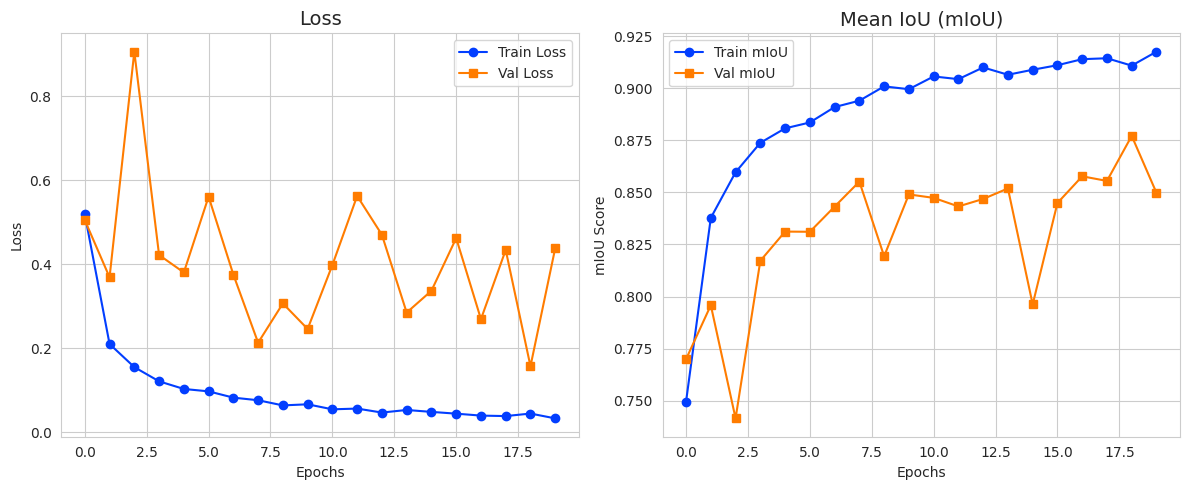

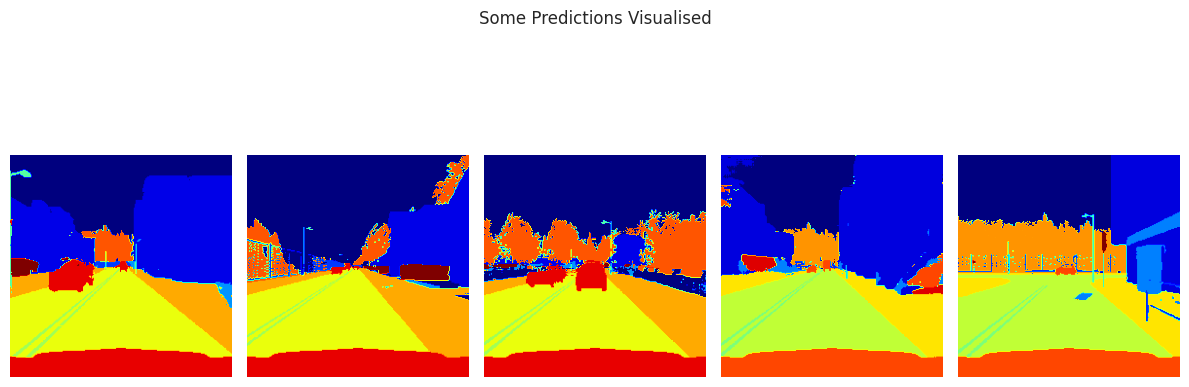

In [17]:
plot_loss_miou_outputs(*losses_mious_vanilla_unet, preds_vanilla_unet)

## Training U-Net without skip connections

In [18]:
# Model Initialization
skipless_unet = UNet(in_channels=3, out_channels=13, model_type="skipless").to(device)

start_time = time.time()
losses_mious_skipless_unet = list(skipless_unet.train_model(train_loader, val_loader, device))
end_time = time.time()

print(f"Time to train: {round(end_time - start_time, 4)} s\n")

print("\nTest Stats:")
preds_skipless_unet, test_loss_skipless_unet, test_miou_skipless_unet = skipless_unet.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_skipless_unet, 4)}")
print(f"Test mIoU = {round(test_miou_skipless_unet, 4)}")

Epoch 1/20: Train Loss=0.6094, Val Loss=0.5368, Train mIoU=0.6836, Val mIoU=0.625


Epoch 2/20: Train Loss=0.3207, Val Loss=0.3647, Train mIoU=0.7636, Val mIoU=0.7481


Epoch 3/20: Train Loss=0.2474, Val Loss=0.2988, Train mIoU=0.7864, Val mIoU=0.7708


Epoch 4/20: Train Loss=0.214, Val Loss=0.3475, Train mIoU=0.7961, Val mIoU=0.7649


Epoch 5/20: Train Loss=0.1871, Val Loss=0.2528, Train mIoU=0.8072, Val mIoU=0.7837


Epoch 6/20: Train Loss=0.1684, Val Loss=0.2351, Train mIoU=0.8161, Val mIoU=0.7942


Epoch 7/20: Train Loss=0.1697, Val Loss=0.2598, Train mIoU=0.815, Val mIoU=0.7832


Epoch 8/20: Train Loss=0.145, Val Loss=0.2725, Train mIoU=0.8274, Val mIoU=0.7876


Epoch 9/20: Train Loss=0.139, Val Loss=0.2295, Train mIoU=0.8309, Val mIoU=0.7993


Epoch 10/20: Train Loss=0.1322, Val Loss=0.1904, Train mIoU=0.8341, Val mIoU=0.8067


Epoch 11/20: Train Loss=0.1246, Val Loss=0.3324, Train mIoU=0.8387, Val mIoU=0.7532


Epoch 12/20: Train Loss=0.1204, Val Loss=0.2364, Train mIoU=0.8413, Val mIoU=0.8049


Epoch 13/20: Train Loss=0.1151, Val Loss=0.2004, Train mIoU=0.8443, Val mIoU=0.8097


Epoch 14/20: Train Loss=0.1109, Val Loss=0.2158, Train mIoU=0.8466, Val mIoU=0.8172


Epoch 15/20: Train Loss=0.1089, Val Loss=0.17, Train mIoU=0.8484, Val mIoU=0.8239


Epoch 16/20: Train Loss=0.1037, Val Loss=0.19, Train mIoU=0.8513, Val mIoU=0.821


Epoch 17/20: Train Loss=0.1007, Val Loss=0.1687, Train mIoU=0.853, Val mIoU=0.825


Epoch 18/20: Train Loss=0.0986, Val Loss=0.1934, Train mIoU=0.8543, Val mIoU=0.8195


Epoch 19/20: Train Loss=0.0962, Val Loss=0.1785, Train mIoU=0.856, Val mIoU=0.8235


Epoch 20/20: Train Loss=0.0937, Val Loss=0.1893, Train mIoU=0.8578, Val mIoU=0.8267
Time to train: 3744.2332 s


Test Stats:
Test loss = 0.1863
Test mIoU = 0.8252


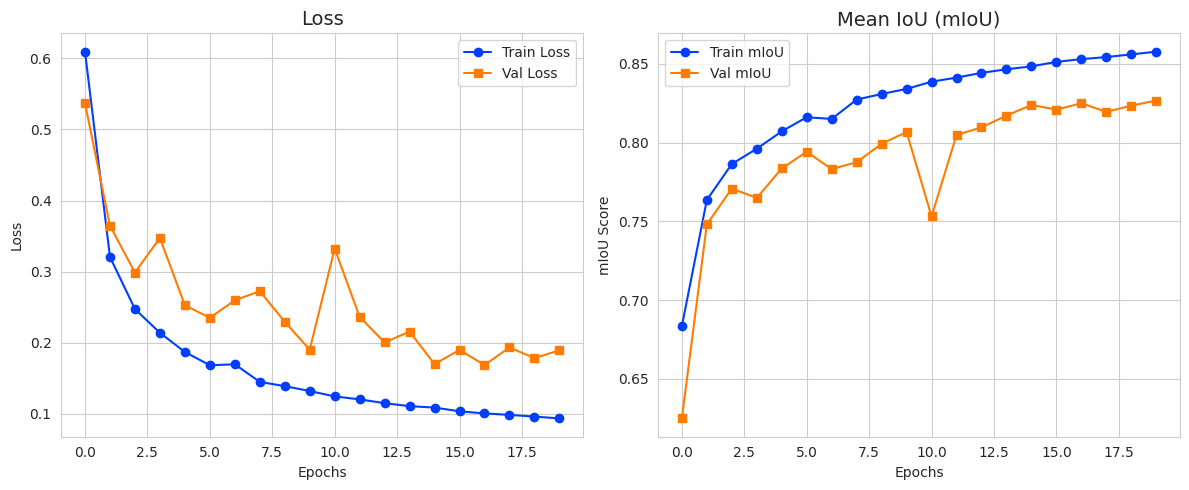

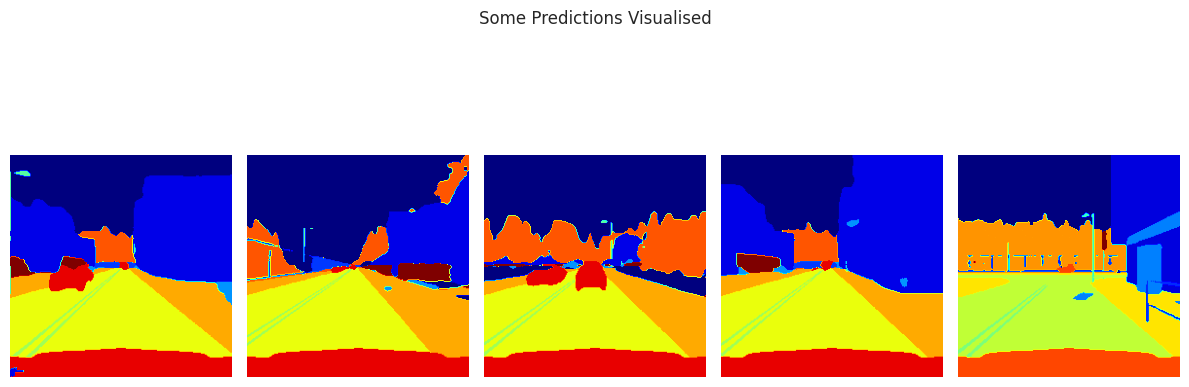

In [19]:
plot_loss_miou_outputs(*losses_mious_skipless_unet, preds_skipless_unet)

## Observations

### U-Net with vs without Skip Connections
- **Vanilla U-Net** (with skips) gives clear, sharp segmentations with better boundary accuracy and captures fine details like poles.
- **Skipless U-Net** gives coarser results, missing thin or small structures and producing blurrier masks.

### Importance of Skip Connections
- Skip connections help **retain spatial details** lost in downsampling.
- They merge low-level encoder features with high-level decoder features, improving segmentation accuracy and preserving edges.
- Without them, the model struggles to localize objects precisely — as seen in the lower mIoU (~83%) for Skipless U-Net.

## Training Residual U-Net

In [20]:
# Model Initialization
residual_unet = UNet(in_channels=3, out_channels=13, model_type="residual").to(device)

start_time = time.time()
losses_mious_residual_unet = list(residual_unet.train_model(train_loader, val_loader, device))
end_time = time.time()

print(f"Time to train: {round(end_time - start_time, 4)} s\n")

print("\nTest Stats:")
preds_residual_unet, test_loss_residual_unet, test_miou_residual_unet = residual_unet.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_residual_unet, 4)}")
print(f"Test mIoU = {round(test_miou_residual_unet, 4)}")

Epoch 1/20: Train Loss=0.5898, Val Loss=0.525, Train mIoU=0.7057, Val mIoU=0.7275


Epoch 2/20: Train Loss=0.2391, Val Loss=0.5806, Train mIoU=0.8139, Val mIoU=0.7336


Epoch 3/20: Train Loss=0.1753, Val Loss=0.4203, Train mIoU=0.8427, Val mIoU=0.7749


Epoch 4/20: Train Loss=0.1416, Val Loss=0.4169, Train mIoU=0.8592, Val mIoU=0.8004


Epoch 5/20: Train Loss=0.1244, Val Loss=0.6094, Train mIoU=0.8675, Val mIoU=0.7586


Epoch 6/20: Train Loss=0.1052, Val Loss=0.268, Train mIoU=0.8775, Val mIoU=0.8255


Epoch 7/20: Train Loss=0.089, Val Loss=0.2741, Train mIoU=0.886, Val mIoU=0.8349


Epoch 8/20: Train Loss=0.0809, Val Loss=0.5834, Train mIoU=0.8906, Val mIoU=0.8067


Epoch 9/20: Train Loss=0.0748, Val Loss=0.5354, Train mIoU=0.8939, Val mIoU=0.8161


Epoch 10/20: Train Loss=0.0669, Val Loss=0.5177, Train mIoU=0.8985, Val mIoU=0.8165


Epoch 11/20: Train Loss=0.0594, Val Loss=1.0329, Train mIoU=0.9029, Val mIoU=0.7899


Epoch 12/20: Train Loss=0.0552, Val Loss=0.9132, Train mIoU=0.9052, Val mIoU=0.8147


Epoch 13/20: Train Loss=0.0563, Val Loss=0.4022, Train mIoU=0.904, Val mIoU=0.7801


Epoch 14/20: Train Loss=0.0476, Val Loss=0.6553, Train mIoU=0.9094, Val mIoU=0.8267


Epoch 15/20: Train Loss=0.0428, Val Loss=0.3526, Train mIoU=0.9122, Val mIoU=0.8382


Epoch 16/20: Train Loss=0.043, Val Loss=0.2937, Train mIoU=0.9119, Val mIoU=0.8486


Epoch 17/20: Train Loss=0.0432, Val Loss=0.341, Train mIoU=0.9116, Val mIoU=0.8426


Epoch 18/20: Train Loss=0.0358, Val Loss=0.3876, Train mIoU=0.9159, Val mIoU=0.8494


Epoch 19/20: Train Loss=0.0362, Val Loss=0.6546, Train mIoU=0.9158, Val mIoU=0.8235


Epoch 20/20: Train Loss=0.035, Val Loss=0.4076, Train mIoU=0.9164, Val mIoU=0.8411
Time to train: 4839.5316 s


Test Stats:
Test loss = 0.4084
Test mIoU = 0.8391


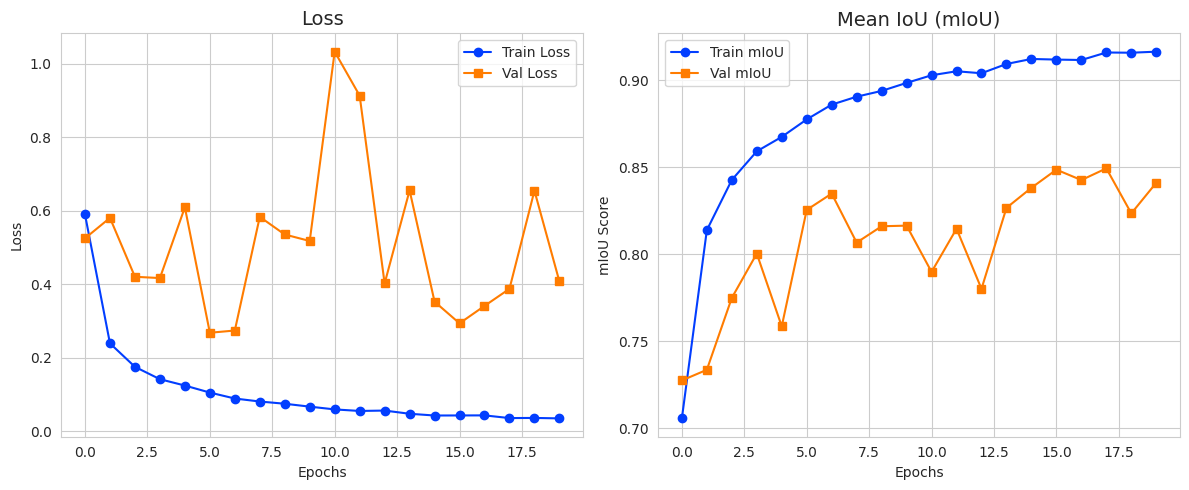

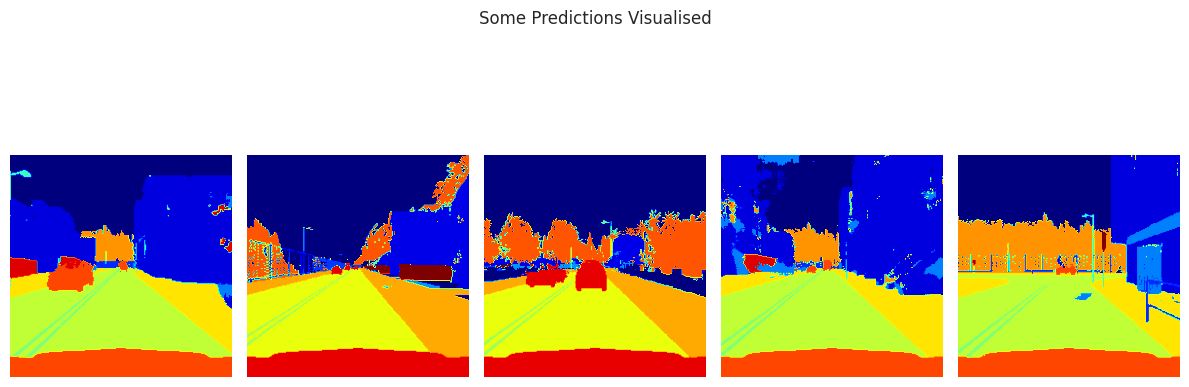

In [21]:
plot_loss_miou_outputs(*losses_mious_residual_unet, preds_residual_unet)

## Training Gated Attention U-Net (with single channel alpha)

In [22]:
# Model Initialization
gated_attention_unet = UNet(in_channels=3, out_channels=13, model_type="gated_attention").to(device)

start_time = time.time()
losses_mious_gated_attention_unet = list(gated_attention_unet.train_model(train_loader, val_loader, device))
end_time = time.time()

print(f"Time to train: {round(end_time - start_time, 4)} s\n")

print("\nTest Stats:")
preds_gated_attention_unet, test_loss_gated_attention_unet, test_miou_gated_attention_unet = gated_attention_unet.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_gated_attention_unet, 4)}")
print(f"Test mIoU = {round(test_miou_gated_attention_unet, 4)}")

Epoch 1/20: Train Loss=0.4933, Val Loss=0.4224, Train mIoU=0.7536, Val mIoU=0.7828


Epoch 2/20: Train Loss=0.2139, Val Loss=0.3545, Train mIoU=0.8364, Val mIoU=0.8072


Epoch 3/20: Train Loss=0.1533, Val Loss=0.2988, Train mIoU=0.8592, Val mIoU=0.8142


Epoch 4/20: Train Loss=0.12, Val Loss=0.3298, Train mIoU=0.8742, Val mIoU=0.8187


Epoch 5/20: Train Loss=0.104, Val Loss=0.3139, Train mIoU=0.8801, Val mIoU=0.8332


Epoch 6/20: Train Loss=0.0869, Val Loss=0.2973, Train mIoU=0.8892, Val mIoU=0.8174


Epoch 7/20: Train Loss=0.0816, Val Loss=0.3543, Train mIoU=0.8909, Val mIoU=0.842


Epoch 8/20: Train Loss=0.069, Val Loss=0.464, Train mIoU=0.898, Val mIoU=0.8386


Epoch 9/20: Train Loss=0.0675, Val Loss=0.338, Train mIoU=0.8985, Val mIoU=0.8437


Epoch 10/20: Train Loss=0.0593, Val Loss=0.2537, Train mIoU=0.9029, Val mIoU=0.8589


Epoch 11/20: Train Loss=0.0537, Val Loss=0.4063, Train mIoU=0.9061, Val mIoU=0.8487


Epoch 12/20: Train Loss=0.0572, Val Loss=0.3515, Train mIoU=0.9035, Val mIoU=0.8395


Epoch 13/20: Train Loss=0.0441, Val Loss=0.2257, Train mIoU=0.9114, Val mIoU=0.8632


Epoch 14/20: Train Loss=0.0445, Val Loss=0.3395, Train mIoU=0.9111, Val mIoU=0.8558


Epoch 15/20: Train Loss=0.0474, Val Loss=0.226, Train mIoU=0.9087, Val mIoU=0.8612


Epoch 16/20: Train Loss=0.0368, Val Loss=0.2844, Train mIoU=0.9155, Val mIoU=0.8659


Epoch 17/20: Train Loss=0.041, Val Loss=0.2873, Train mIoU=0.9132, Val mIoU=0.8677


Epoch 18/20: Train Loss=0.0446, Val Loss=0.2348, Train mIoU=0.9114, Val mIoU=0.8685


Epoch 19/20: Train Loss=0.032, Val Loss=0.1983, Train mIoU=0.9183, Val mIoU=0.8718


Epoch 20/20: Train Loss=0.0358, Val Loss=0.2309, Train mIoU=0.916, Val mIoU=0.8701
Time to train: 4614.9701 s


Test Stats:
Test loss = 0.2285
Test mIoU = 0.8668


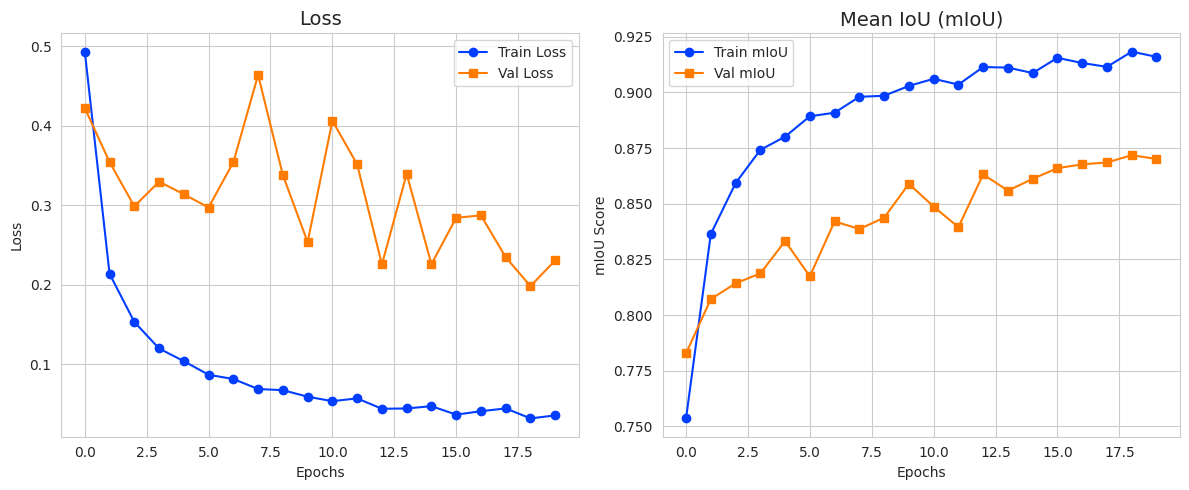

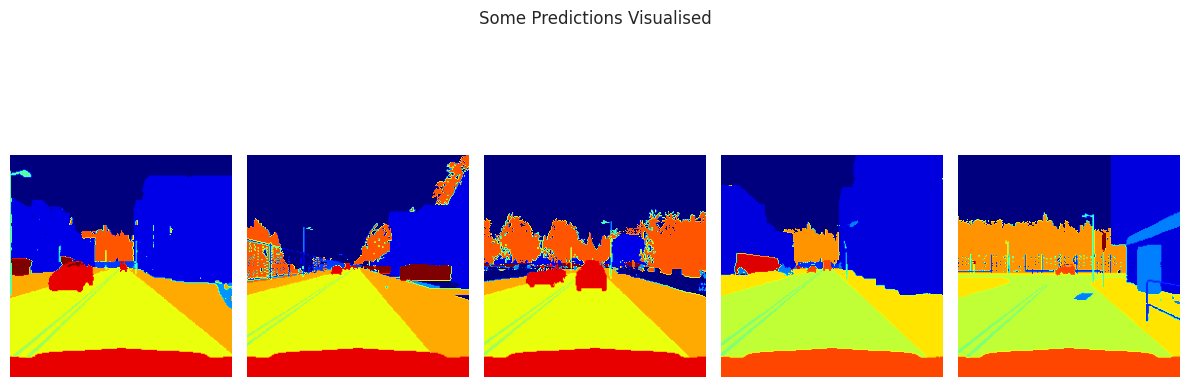

In [23]:
plot_loss_miou_outputs(*losses_mious_gated_attention_unet, preds_gated_attention_unet)

## Visualising all outputs together for comparison for 3 choosen images

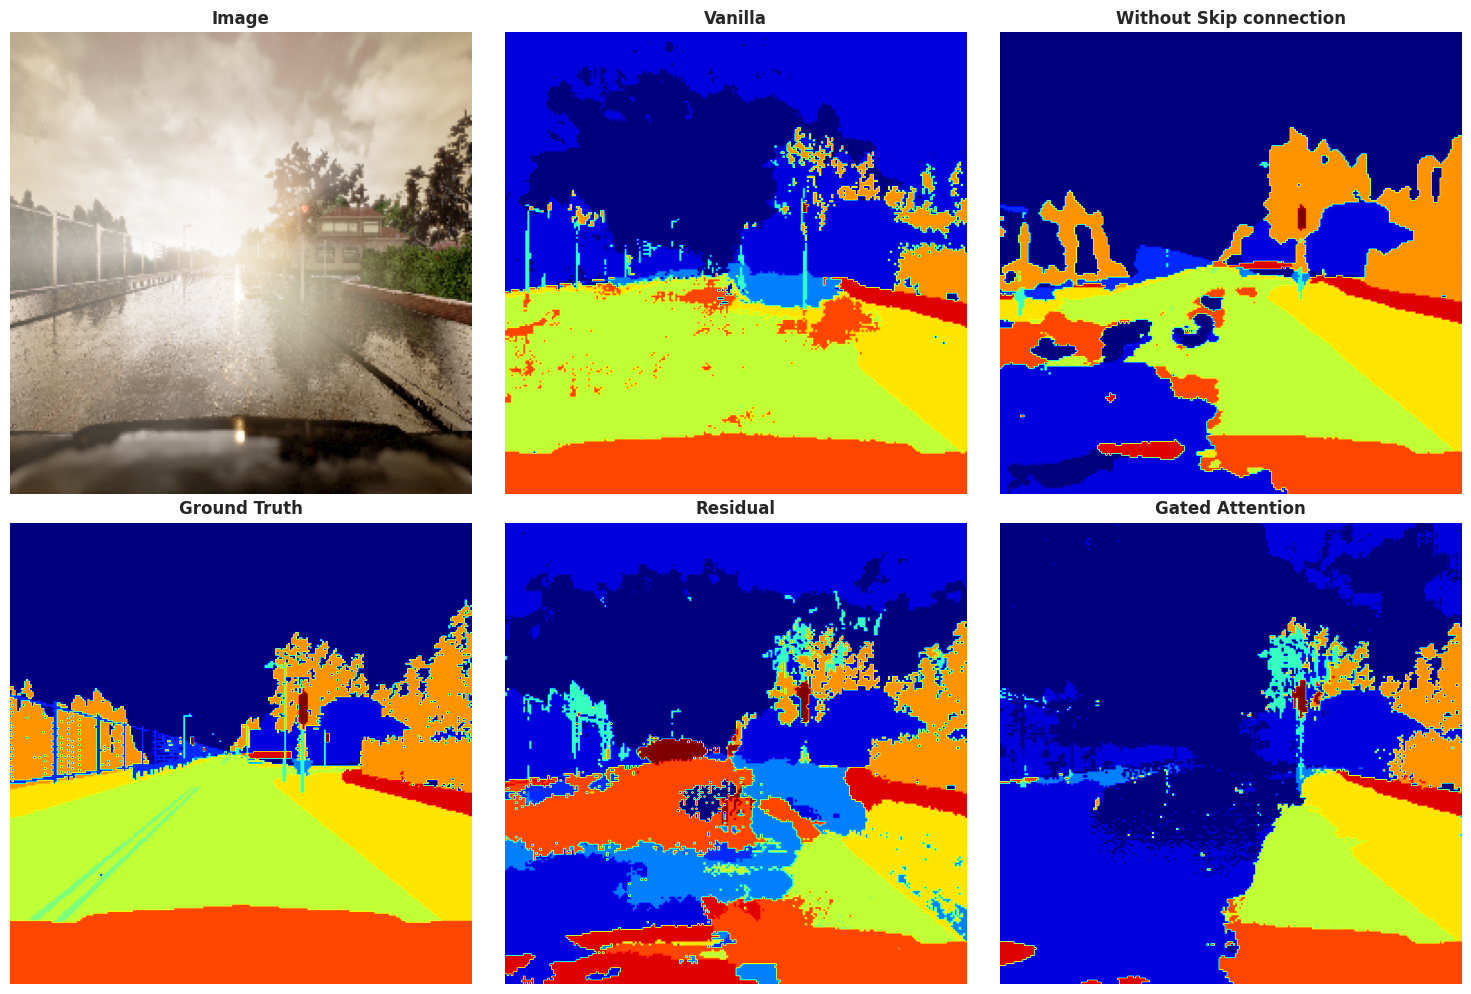

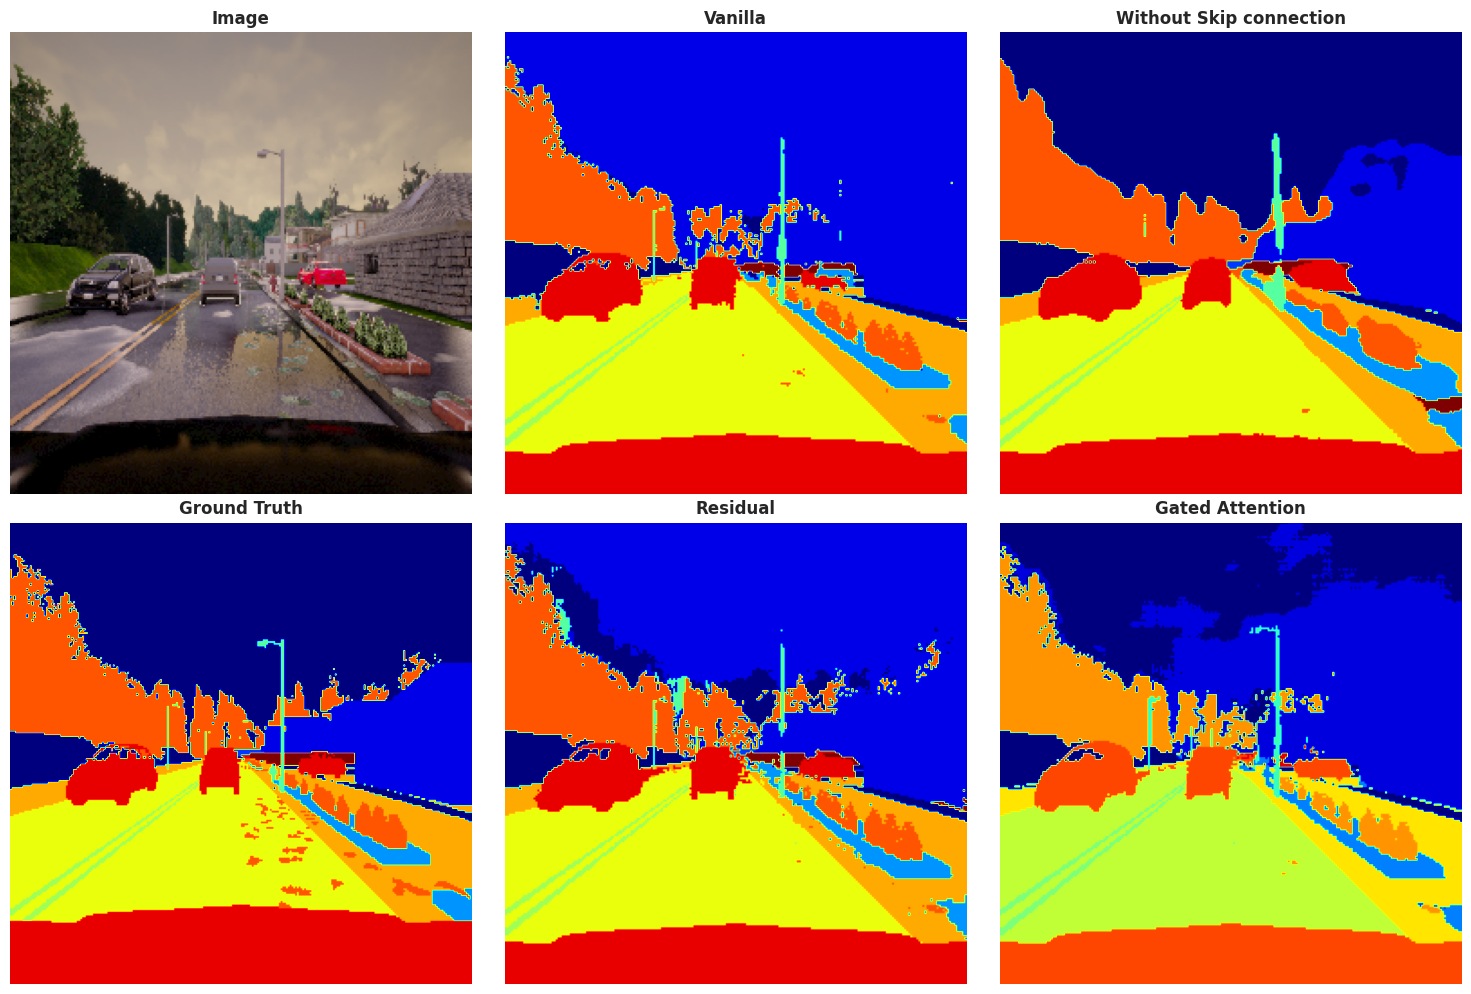

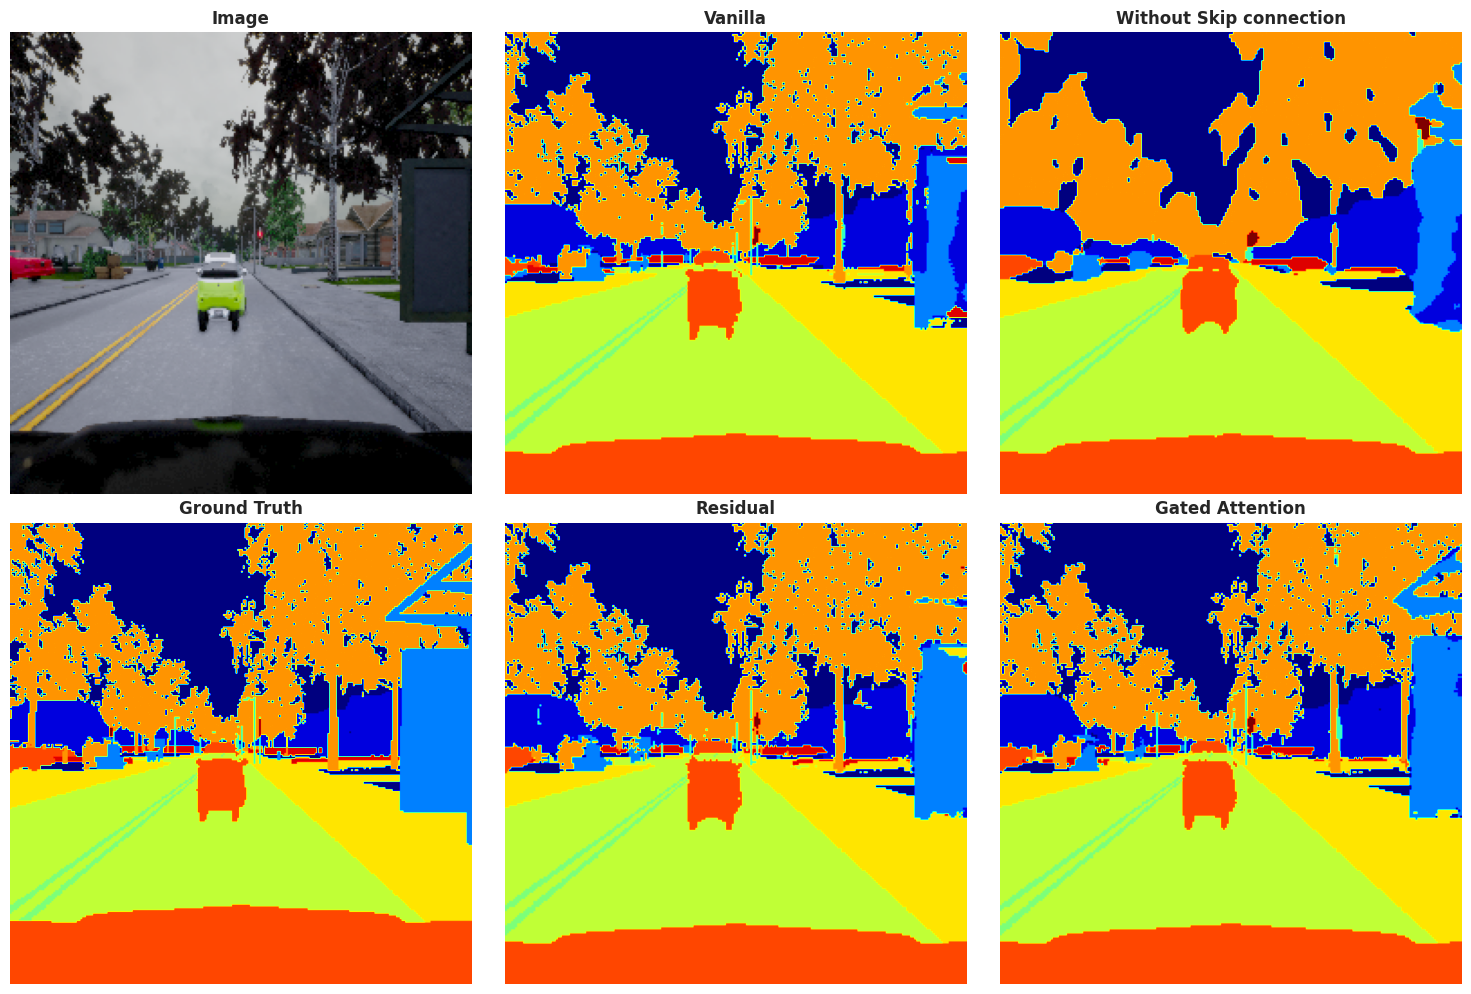

In [24]:
def visualise_segmentation_results(test_images, test_masks, preds_vanilla_unet, preds_skipless_unet, preds_residual_unet, preds_gated_attention_unet, i_s=[10, 15, 20]):
    for i in i_s:
        sns.set_style("white")
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        titles = ["Image", "Vanilla", "Without Skip connection",
                  "Ground Truth", "Residual", "Gated Attention",]
        
        images = [np.int32(test_images[i]), preds_vanilla_unet[i], preds_skipless_unet[i],
                  test_masks[i], preds_residual_unet[i], preds_gated_attention_unet[i]]
        
        for ax, img, title in zip(axes.flat, images, titles):
            ax.imshow(img if title == "Image" else img, cmap=None if title == "Image" else seg_map)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

visualise_segmentation_results(test_images, test_masks, preds_vanilla_unet, preds_skipless_unet, preds_residual_unet, preds_gated_attention_unet)

<style>
table {
    width: 100%;
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    text-align: center;
}
th, td {
    border: 1px solid #ddd;
    padding: 10px;
}
th {
    background-color: #4CAF50;
    color: white;
}
tr:nth-child(even) {
    background-color: #f2f2f2;
    color: black;
}
td:first-child, th:first-child {
    font-weight: bold;
}
</style>

<table>
    <tr>
        <th>Model</th>
        <th>Final Train Loss</th>
        <th>Final Train IoU</th>
        <th>Final Val Loss</th>
        <th>Final Val mIoU</th>
        <th>Test Loss</th>
        <th>Test mIoU</th>
        <th>Train time (s)</th>
        <th>Epochs</th>
    </tr>
    <!-- Vanilla UNet -->
    <tr>
        <th>Vanilla UNet</th>
        <td>0.0334</td>
        <td>0.9175</td>
        <td>0.4384</td>
        <td>0.8497</td>
        <td>0.4497</td>
        <td>0.8488</td>
        <td>4264.6813</td>
        <td>20</td>
    </tr>
    <!-- UNet without skip connection -->
    <tr>
        <th>Skipless UNet</th>
        <td>0.0937</td>
        <td>0.8578</td>
        <td>0.1893</td>
        <td>0.8267</td>
        <td>0.1863</td>
        <td>0.8252</td>
        <td>3744.2332</td>
        <td>20</td>
    </tr>
    <!-- Residual UNet -->
    <tr>
        <th>Residual UNet</th>
        <td>0.035</td>
        <td>0.9164</td>
        <td>0.4076</td>
        <td>0.8411</td>
        <td>0.4084</td>
        <td>0.8391</td>
        <td>4839.5316</td>
        <td>20</td>
    </tr>
    <!-- Gated Attention UNet -->
    <tr>
        <th>Gated Attention UNet</th>
        <td>0.0358</td>
        <td>0.916</td>
        <td>0.2309</td>
        <td>0.8701</td>
        <td>0.2285</td>
        <td>0.8668</td>
        <td>4614.9701</td>
        <td>20</td>
    </tr>
</table>

## Visualising results (Code generated by ChatGPT: https://chatgpt.com/share/67eccbea-42c4-8003-b1e7-a337a45126e8)
#### This is the visual representation of the above table

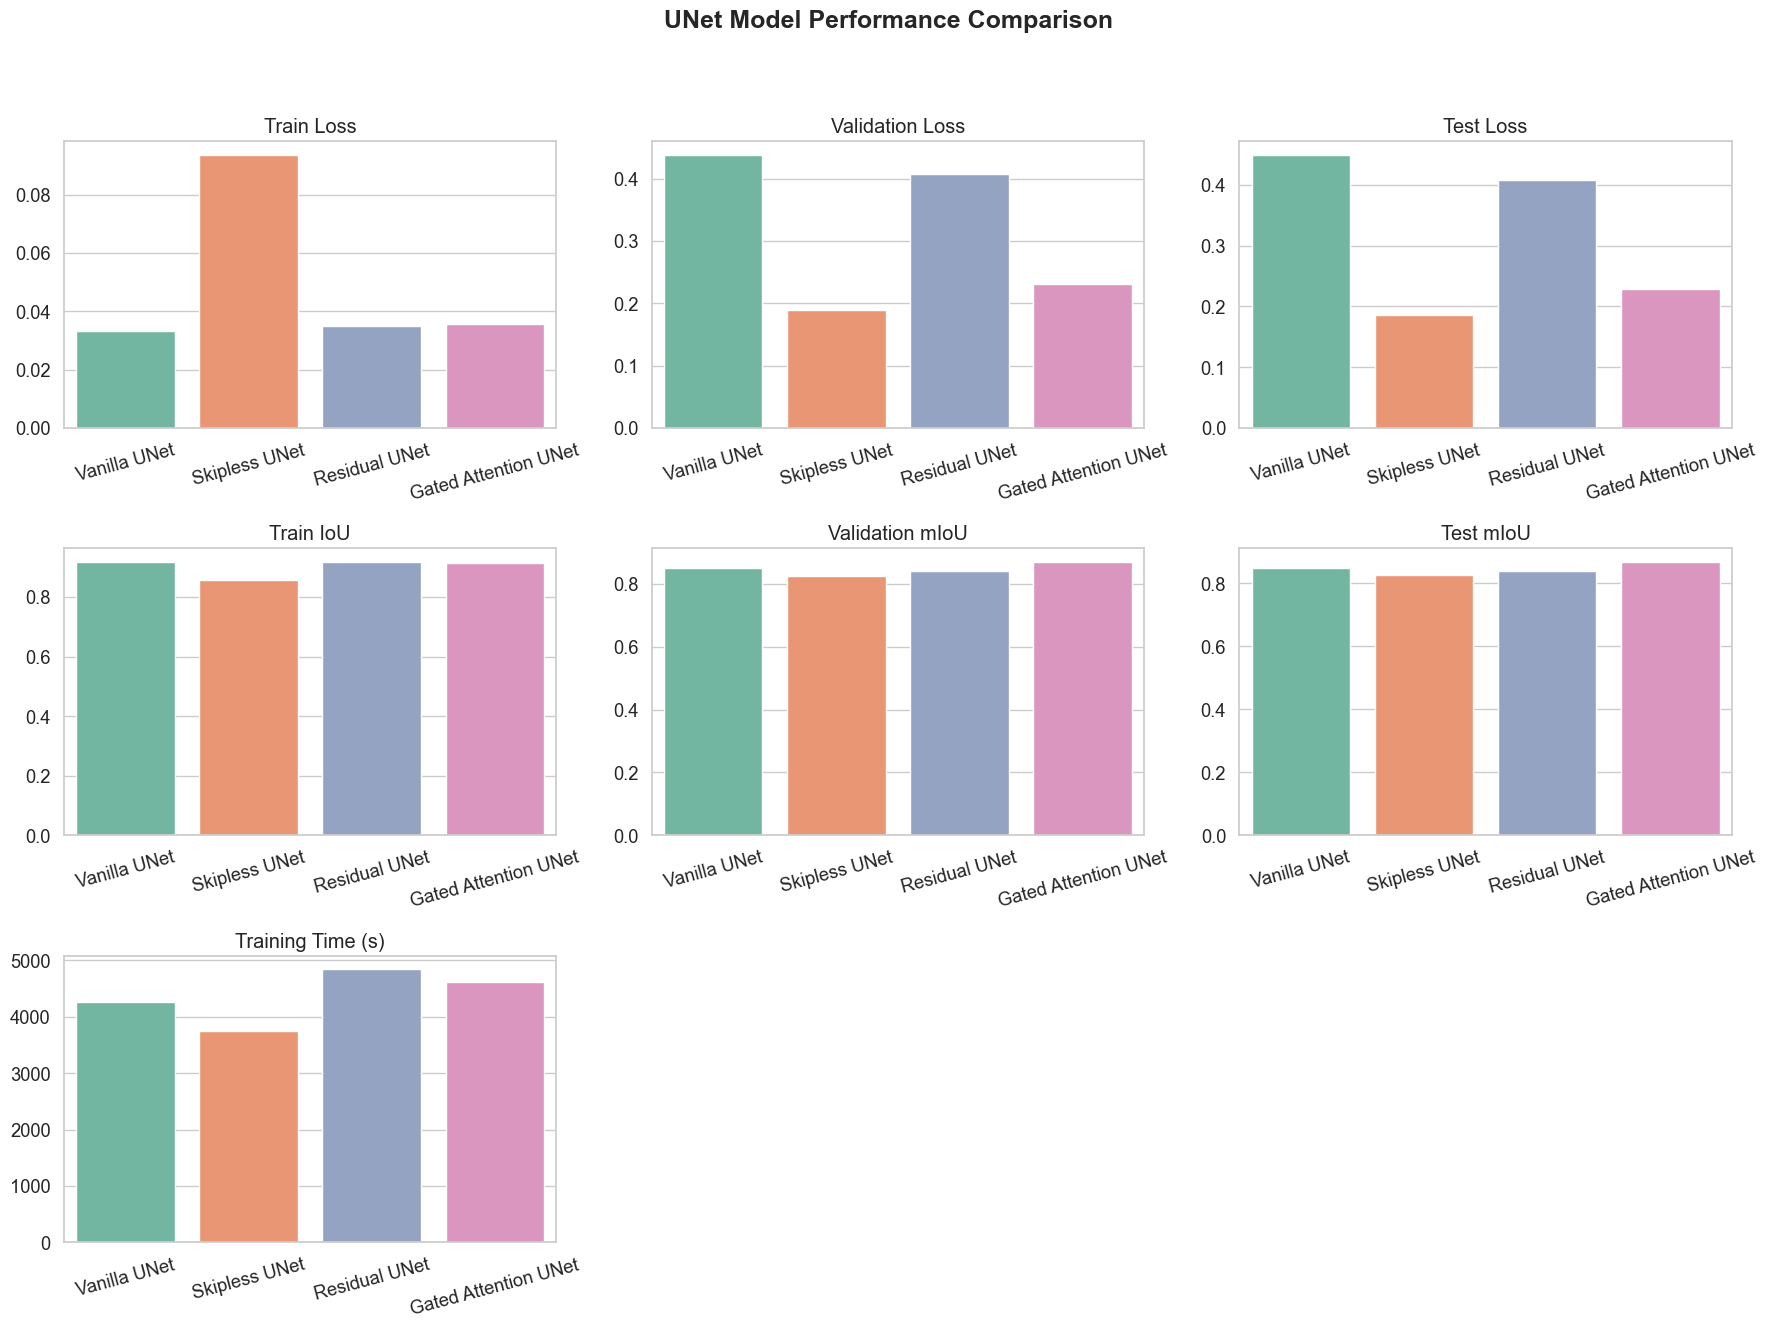

In [ ]:
# Data dictionary
data = {
    "Model": ["Vanilla UNet", "Skipless UNet", "Residual UNet", "Gated Attention UNet"],
    "Final Train Loss": [0.0334, 0.0937, 0.035, 0.0358],
    "Final Train IoU": [0.9175, 0.8578, 0.9164, 0.916],
    "Final Val Loss": [0.4384, 0.1893, 0.4076, 0.2309],
    "Final Val mIoU": [0.8497, 0.8267, 0.8411, 0.8701],
    "Test Loss": [0.4497, 0.1863, 0.4084, 0.2285],
    "Test mIoU": [0.8488, 0.8252, 0.8391, 0.8668],
    "Train time (s)": [4264.6813, 3744.2332, 4839.5316, 4614.9701],
    "Epochs": [20, 20, 20, 20]
}

df = pd.DataFrame(data)

# Set Seaborn theme
sns.set(style="whitegrid", palette="Set2", font_scale=1.2)

# Plotting metrics
metrics_to_plot = [
    ("Final Train Loss", "Train Loss"),
    ("Final Val Loss", "Validation Loss"),
    ("Test Loss", "Test Loss"),
    ("Final Train IoU", "Train IoU"),
    ("Final Val mIoU", "Validation mIoU"),
    ("Test mIoU", "Test mIoU"),
    ("Train time (s)", "Training Time (s)")
]

# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

for i, (col, title) in enumerate(metrics_to_plot):
    sns.barplot(x="Model", y=col, data=df, ax=axes[i], hue="Model", dodge=False)
    axes[i].set_title(title)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', rotation=15)

# Hide extra axes if any
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Overall title
plt.suptitle("UNet Model Performance Comparison", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Observations

### Vanilla U-Net vs Gated Attention U-Net
- Both models perform well with high mIoU (~85–87%), but **Gated Attention U-Net** slightly outperforms Vanilla U-Net in **val and test mIoU**.
- **Gated model** produces cleaner segmentations, especially in cluttered regions, by focusing on relevant features.
- It helps suppress background noise and improves detection of important structures compared to Vanilla U-Net.

### Summary
- **Gated Attention U-Net** gives better precision in complex areas.
- **Vanilla U-Net** is strong, but lacks the targeted feature refinement that attention provides.

## Advantages of Attention Gated UNet
- **Focus on Targets**: AGs learn to highlight important structures of varying shapes and sizes without extra supervision.
- **Enhance Saliency**: AGs highlight task-relevant features, boosting segmentation accuracy and sensitivity.
- **No Need for External Modules**: AGs eliminate the need for separate localization networks, simplifying the pipeline.
- **Lightweight Integration**: Easily added to existing models like U-Net with minimal computational cost.
- **Grid-Based Gating**: Enables local attention using spatially aware gating signals.

### Role of Gating Signal at Skip Connections
- **Feature Selectivity**: Combines local and contextual info to retain only important features.
- **Multi-Scale Awareness**: Aggregates features across scales for better spatial understanding.
- **Boundary Focus**: Over training, AGs learn to emphasize object boundaries, improving segmentation detail.